In [1]:
from dabench import data, dacycler, model, obsop, observer, vector
import numpy as np
import matplotlib.pyplot as plt

# Define data generator

In [2]:
# First define data generator and generate data
l96 = data.Lorenz96(system_dim=6)

In [3]:
l96.generate(n_steps=2000)

# Define model

In [4]:
l96_for_model = data.Lorenz96(system_dim=6)

class L96Model(model.Model):                                                                       
    """Defines model wrapper for Lorenz63 to test forecasting."""
    def forecast(self, state_vec):
        self.model_obj.generate(x0=state_vec.values, n_steps=2)
        new_vals = self.model_obj.values[-1]

        new_vec = vector.StateVector(values=new_vals)

        return new_vec

In [5]:
our_model = L96Model(model_obj=l96_for_model)

# Generate observations

In [6]:
# Now we can define the observer:
obs_l96 = observer.Observer(
    l96, # Data generator object
    random_time_density = 0.7, # Probability of picking each time step for random sampling
    random_location_count = 3, # Probability of picking each location in l63.system_dim for random sampling
    error_bias = 0.0, # Mean for observation error, Gaussian/Normal distribution
    error_sd = 0.7, # Standard deviation for observation error, Gaussian/Normal distribution
    random_seed=94, # We can specify a random seed. Default is 99
    stationary_observers=True
)

# Making observations
obs_vec_l96 = obs_l96.observe()

# Define DA Cycler

In [7]:
dc = dacycler.Var3D(system_dim=l96.system_dim, delta_t=l96.delta_t, model_obj=our_model)

In [8]:
# Could wrap all this up in a "mega" cycle method for simplicity

# Set starting timestep
cur_tstep = 1000
# Starting state
new_forecast = vector.StateVector(values=l96.values[cur_tstep])

# For storing outputs
all_anlsys = []
all_times=[]

for i in range(200):
    # 1. Get time
    cur_time = l96.times[cur_tstep]
    all_times.append(cur_time)

    # 2. Filter observations to plus/minus 0.1 from that time
    obs_vec_timefilt = obs_vec_l96.filter_times(cur_time-0.1, cur_time+0.1)
    
    if obs_vec_timefilt.values.shape[0] > 0:
        # 3. Calculate analysis
        anlsys, kh = dc.cycle(new_forecast, obs_vec_timefilt)
        # 4. Forecast next timestep
        new_forecast = dc.forecast(anlsys)
        # 5. Save outputs
        all_anlsys.append(anlsys.values)
    else:
        all_anlsys.append(None)

    cur_tstep += 1

In [9]:
cycled_vals = np.stack(all_anlsys)

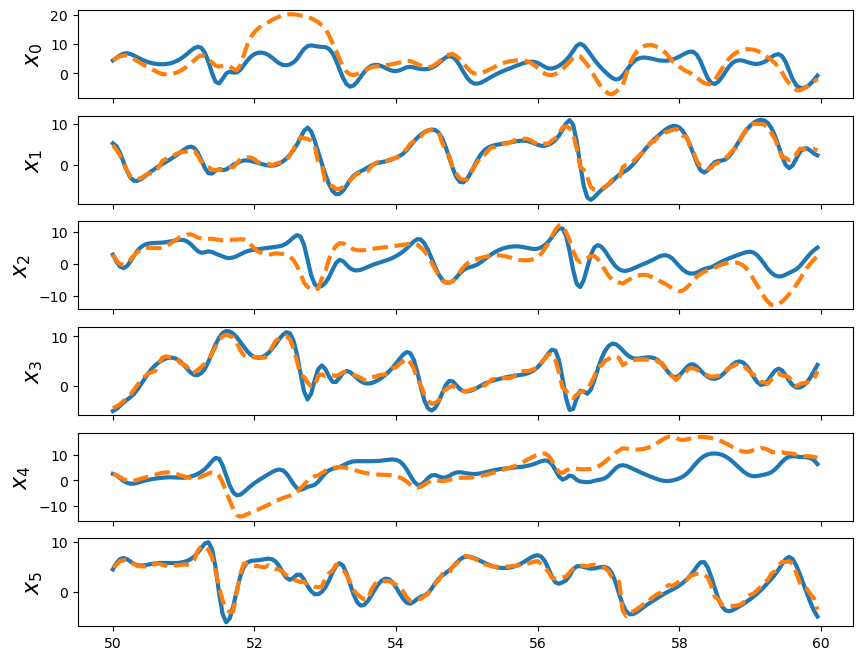

In [10]:
fig, axes = plt.subplots(6, 1, sharex = True, figsize = (10, 8))
for j, ax in enumerate(axes):
    ax.plot(all_times, l96.values[1000:1200,j], lw = 3, label = 'True')
    ax.plot(all_times, cycled_vals[:,j], lw = 3, ls = '--', label = 'Pred')
    ax.set_ylabel(r'$x_{:d}$'.format(j), fontsize = 16)